## It has code for 2 factors
- Spell Checking - More spelling error means mostly writeen by un-professionals and may be a fake news
- Political Affiliation - I initially thought of geography , but could not apply that to dataset

In [344]:
import numpy as np
import pandas as pd

In [345]:
columns=['id','label','statement','subject','speaker','speaker_job','state',
        'party_affiliation','barely_true_count','false_Count',
        'half_true_count','mostly_true_count','pants_on_fire_count','venue_speach'];
df_lair=pd.read_csv('train.tsv',sep='\t',header=None,names=columns,index_col=False);
df_lair.head()

,id,label,statement,subject,speaker,speaker_job,state,party_affiliation,barely_true_count,false_Count,half_true_count,mostly_true_count,pants_on_fire_count,venue_speach
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [346]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chidananda.pati/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/chidananda.pati/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chidananda.pati/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Text Proprocessing

#### Function for text preprocessing
- lowercase the text
- word tokenization
- remove stop words and non alphanumeric charaters
- stemming

In [347]:
from nltk.stem import PorterStemmer,WordNetLemmatizer
def text_preprocessing(df_base):
    df=df_base.copy()
    # lowercase the text
    df['statement']=df['statement'].str.lower()
    # word tokenization
    df['statement']=df['statement'].map(lambda x: nltk.word_tokenize(x))
    # remove stop words and non alphanumeric charaters
    df['statement']=df['statement'].map(lambda x: [w for w in x if (not w in stop_words) and w.isalpha()])
    # lemmatization
    wordnet_lemmatizer = WordNetLemmatizer()
    df['statement']=df['statement'].map(lambda x: [ wordnet_lemmatizer.lemmatize(w) for w in x])    
    # stemming
    porter = PorterStemmer()
    df['statement']=df['statement'].map(lambda x: [porter.stem(w) for w in x] )
    return df

#### Calling text_preprocessing function

In [348]:
df_train=text_preprocessing(df_lair)
df_train.head()

,id,label,statement,subject,speaker,speaker_job,state,party_affiliation,barely_true_count,false_Count,half_true_count,mostly_true_count,pants_on_fire_count,venue_speach
0,2635.json,false,"[say, anni, list, polit, group, support, abort...",abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,"[declin, coal, start, start, natur, ga, took, ...","energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"[hillari, clinton, agre, john, mccain, vote, g...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,"[health, care, reform, legisl, like, mandat, f...",health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,"[econom, turnaround, start, end, term]","economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


## Spelling Error Check Factor
### using nltk wordnet and enchant

function spell_check_article - It takes an article as input and returns number of words with spelling error in an article and % of words with errors
- pip install pyenchant

In [349]:
from nltk.corpus import wordnet
import enchant
enchant = enchant.Dict("en_US")
def spell_check_article(article):
    article=article.replace('-',' ');
    article_tokenized=nltk.word_tokenize(article)
    total_word_count=len(article_tokenized)
    words_with_error_count=0
    for w in article_tokenized:
        if (not wordnet.synsets(w)) and (not enchant.check(w)):
            words_with_error_count+=1
    return words_with_error_count,(words_with_error_count/total_word_count*100)

In [350]:
spell_check_article('kitten drining choclate malk')

(3, 75.0)

In [351]:
spell_check_article('kitten drining choclate milk')

(2, 50.0)

In [352]:
df_lair['spell_error']=df_lair['statement'].map(lambda x: spell_check_article(x)[0])
df_lair[['statement','spell_error']].head()

,statement,spell_error
0,Says the Annies List political group supports ...,1
1,When did the decline of coal start? It started...,3
2,"Hillary Clinton agrees with John McCain ""by vo...",2
3,Health care reform legislation is likely to ma...,0
4,The economic turnaround started at the end of ...,0


## Tag Cloud
To understand most frequent words in the corpus
- pip install wordcloud

In [353]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [354]:
statements=''.join(df_lair['statement'].values.tolist())

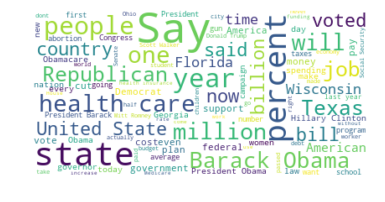

In [355]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(statements)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Conclusion is corpus looks like is mostly political and money related

## Word2Vec to create a vector representation of processed words for every article
- pip install gensim

In [356]:
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [357]:
LabeledSentence = gensim.models.doc2vec.LabeledSentence

In [358]:
def labelled_sentences(articles, label_type):
    labelledSentences = []
    for i,_d in enumerate(articles):
        labelledSentences.append(LabeledSentence(_d, label_type[i]))
    return labelledSentences

In [359]:
df_train_labelled=labelled_sentences(df_train['statement'],df_train['label'])
df_train_labelled[1]

LabeledSentence(words=['declin', 'coal', 'start', 'start', 'natur', 'ga', 'took', 'start', 'begin', 'presid', 'georg', 'bush', 'administr'], tags='half-true')

In [360]:
tagged_data = [TaggedDocument(words=_d, tags=[str(i)]) for i, _d in enumerate(df_train['statement'])]

In [361]:
tagged_data_words=[x.words for x in tagged_data]
tagged_data_words_1D=[]
for row in range(len(tagged_data_words)):
    for col in range(len(tagged_data_words[row])):
        tagged_data_words_1D.append(tagged_data_words[row][col]) 

In [362]:
n_dim=300
w2v = Word2Vec(size=n_dim, min_count=0)
w2v.build_vocab(tagged_data_words)
w2v.train(tagged_data_words,total_examples=w2v.corpus_count,epochs=w2v.epochs)

(475961, 524220)

In [363]:
w2v.most_similar('polit')

[('washington', 0.9999654293060303),
 ('report', 0.9999611377716064),
 ('made', 0.9999591112136841),
 ('know', 0.9999569058418274),
 ('militari', 0.9999565482139587),
 ('thing', 0.9999565482139587),
 ('union', 0.9999564290046692),
 ('sent', 0.9999532699584961),
 ('rule', 0.9999518394470215),
 ('terrorist', 0.9999511241912842)]

In [376]:
df_train_statements=df_train[['statement','label']]
df_train_statements_vectorized=df_train_statements['statement'].map(lambda x: [w2v[w] for w in x])

In [377]:
df_train_statements['statement']=df_train_statements_vectorized

In [378]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_train_statements['label']=le.fit_transform(df_train_statements['label'])

In [379]:
df_train_statements.head()

,statement,label
0,"[[0.3633189, -0.20932719, -0.015843494, 0.2497...",1
1,"[[0.064288534, -0.04812693, -0.0062397104, 0.0...",2
2,"[[0.28765804, -0.10001419, 0.0049995263, 0.153...",3
3,"[[0.17699249, -0.29522, 0.09164787, 0.1953922,...",1
4,"[[0.21530126, -0.15957269, -0.017955817, 0.150...",2


In [380]:
#list(le.inverse_transform(df_train_statements['label']))

In [381]:
def document_vector(doc):
    return np.mean(doc, axis=0)

In [382]:
for row_idx in range(len(df_train_statements['statement'])):
    for col_idx in range(len(df_train_statements['statement'][row_idx])):
        df_train_statements['statement'][row_idx][col_idx]=document_vector(df_train_statements['statement'][row_idx][col_idx])

In [383]:
#df_train_statements['statement']=df_train_statements['statement'].map(document_vector)
df_train_statements.drop(index=4497,inplace=True)
df_train_statements.reset_index(drop=True)

,statement,label
0,"[0.021604802, 0.0002024563, 0.005585308, 0.010...",1
1,"[0.0035548727, 0.004597977, 0.011129816, 0.011...",2
2,"[0.016630093, 0.025745373, 0.0058948766, 0.016...",3
3,"[0.01993456, 0.015543409, 0.012205623, 0.01347...",1
4,"[0.012149385, 0.0012879493, 0.011129816, 0.011...",2
5,"[0.0024724388, 0.0027609733, 0.011129816, 0.00...",5
6,"[0.0064215367, 0.00038952148, 0.012252209, 0.0...",0
7,"[0.012156806, 0.003740972, 0.015015611, 0.0053...",2
8,"[0.00037979402, 0.014680496, 0.015814679, 0.01...",2
9,"[0.021604802, 0.0060035465, 0.007388552, 0.007...",3


##### Making word vec to features

In [384]:
texts=[]
for x in df_train_statements['statement'].values:
    texts.append(x)   
X=pd.DataFrame(texts)
X=X.fillna(0)
y=df_train_statements[['label']]
X_train,X_test,y_train,y_test=train_test_split(X, y,test_size = .2, random_state = 1)

In [395]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
8893,0.010436,0.002506,0.016052,0.001775,0.015762,0.014749,0.005076,0.014820,0.014749,0.004573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2933,0.003821,0.004616,0.017296,0.005807,0.004852,0.016145,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3933,0.003198,0.013464,0.013139,0.016214,0.014540,0.014375,0.014375,0.009797,0.010342,0.014540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3406,0.021711,0.023639,0.018783,0.003691,0.012512,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7210,0.021605,0.017930,0.004573,0.006458,0.000687,0.001480,0.003363,0.005370,0.005327,0.009119,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [396]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(X_train, y_train)
gnb_pred = gnb.predict(X_test)

In [397]:
print(metrics.classification_report(y_test,gnb_pred))

             precision    recall  f1-score   support

          0       0.25      0.00      0.01       292
          1       0.00      0.00      0.00       408
          2       0.14      0.01      0.02       440
          3       0.00      0.00      0.00       420
          4       0.08      0.97      0.15       167
          5       0.00      0.00      0.00       321

avg / total       0.07      0.08      0.02      2048



In [398]:
from sklearn.ensemble import RandomForestClassifier
# Lets try with 100 trees
num_trees=100
rf=RandomForestClassifier(n_estimators=num_trees)
rf.fit(X_train, y_train)
rf_pred=rf.predict(X_test)

In [399]:
print(metrics.classification_report(y_test,rf_pred))

             precision    recall  f1-score   support

          0       0.16      0.14      0.15       292
          1       0.25      0.27      0.26       408
          2       0.25      0.35      0.29       440
          3       0.21      0.23      0.22       420
          4       0.12      0.02      0.04       167
          5       0.17      0.13      0.15       321

avg / total       0.21      0.22      0.21      2048



## Doc2Vec

In [400]:
from gensim.models.doc2vec import Doc2Vec

In [401]:
df_train_statements_d2v=df_train[['statement','label']]

In [402]:
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    #print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha
    
model.save("d2v.model")
print("Model Saved")    

Model Saved


In [403]:
model= Doc2Vec.load("d2v.model")
texts=[]
for x in df_train_statements_d2v['statement']:
    texts.append(model.infer_vector(x))

In [404]:
X=pd.DataFrame(texts)
y=df_train_statements_d2v[['label']]
X_train,X_test,y_train,y_test=train_test_split(X, y,test_size = .3, random_state = 1)

In [405]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
3474,0.297424,-0.494376,0.504700,-0.022906,-0.141586,0.190958,-0.160766,-0.007874,-0.014250,-0.212981,0.321681,-0.323559,-0.105271,0.355406,0.032510,0.260020,-0.000886,0.003739,0.323817,0.039400
6202,0.007148,0.032191,0.020678,-0.030780,-0.114297,0.026094,0.041957,0.007013,-0.069188,-0.074388,-0.035606,-0.007954,-0.129842,0.045046,0.140375,0.113730,-0.016142,-0.102469,0.062706,0.097905
5868,0.250376,-0.483914,0.479165,-0.049031,-0.165506,-0.228796,-0.442139,0.134156,0.165140,-0.163247,0.028587,-0.177672,-0.507957,0.597177,0.138022,0.512237,-0.132059,0.044215,0.487921,-0.069746
7357,0.070637,-0.087275,0.068983,-0.024520,-0.098744,0.052397,-0.061659,0.031336,-0.087490,-0.073199,0.120813,-0.022100,-0.051640,0.262692,0.023924,0.169896,-0.095457,-0.002651,0.133761,0.038768
9514,0.106664,-0.174462,0.040475,0.149133,-0.186433,0.068184,-0.043129,0.100722,-0.043550,-0.027542,0.047767,-0.112149,-0.026784,0.212077,-0.028058,0.111285,0.064596,-0.046252,0.081631,-0.088983


In [406]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(C=100)
logisticRegr.fit(X_train, y_train)
lr_pred = logisticRegr.predict(X_test)

In [408]:
print(metrics.classification_report(y_test,lr_pred))

             precision    recall  f1-score   support

barely-true       0.16      0.08      0.11       467
      false       0.22      0.40      0.29       612
  half-true       0.24      0.35      0.28       649
mostly-true       0.23      0.23      0.23       586
 pants-fire       0.00      0.00      0.00       252
       true       0.26      0.08      0.12       506

avg / total       0.20      0.22      0.20      3072



In [409]:
from sklearn.ensemble import RandomForestClassifier
# Lets try with 100 trees
num_trees=100
rf=RandomForestClassifier(n_estimators=num_trees)
rf.fit(X_train, y_train)
rf_pred=rf.predict(X_test)

In [410]:
print(metrics.classification_report(y_test,rf_pred))

             precision    recall  f1-score   support

barely-true       0.19      0.18      0.19       467
      false       0.22      0.26      0.23       612
  half-true       0.23      0.34      0.27       649
mostly-true       0.21      0.24      0.22       586
 pants-fire       0.09      0.00      0.01       252
       true       0.17      0.09      0.12       506

avg / total       0.20      0.21      0.20      3072



In [411]:
similar_doc = model.docvecs.most_similar('1')
print(similar_doc)

[('2625', 0.751284122467041), ('339', 0.7445544600486755), ('2491', 0.7444988489151001), ('8783', 0.7416277527809143), ('8059', 0.7405910491943359), ('4645', 0.7367343902587891), ('5714', 0.7319438457489014), ('5263', 0.7254881262779236), ('9679', 0.7244449853897095), ('4319', 0.7136104106903076)]


### K-means for vectorized docs

In [316]:
from nltk.cluster import KMeansClusterer

In [317]:
#Taking a very long time
kclusterer = KMeansClusterer(5, distance=nltk.cluster.util.cosine_distance, repeats=5)
assigned_clusters = kclusterer.cluster(texts, assign_clusters=True)
assigned_clusters[0]

4

In [1105]:
#for i, word in enumerate(texts):  
#    print (texts[i] , assigned_clusters[i])
print (texts[1] , assigned_clusters[1])

[ 0.14927846 -1.1621119  -0.9016655  -0.09167448 -0.43202588 -0.38233116
  0.11902588 -0.24962123  0.80018884 -0.37761986 -1.2990891  -1.5778913
 -0.0123128  -0.65936774  0.76382226  1.6621412   0.89860374  0.6922449
  2.2779279   0.04066165] 3


In [318]:
from sklearn.cluster import KMeans as km
import matplotlib.pyplot as plt
def kmeans_plot(k):
    kmeans=km(n_clusters=k,random_state=0).fit(texts)
    labels=kmeans.labels_
    centroids=kmeans.cluster_centers_    
    colors = ['r','g','b','y','c','m','r','g','b','y','c','m','r','g','b','y','c','m']
    fig, ax=plt.subplots()
    
    for i in range(k):
        points=np.array([texts[j] for j in range(len(texts)) if labels[j]==i])
        ax.scatter(points[:,0],points[:,1],s=7,c=colors[i])
    ax.scatter(centroids[:,0],centroids[:,1],marker='*',s=200,c='#050505')     
kmeans_plot(5)    

## LDA Topic Modelling to see if we can find any topic

In [332]:
from gensim import corpora, models

In [333]:
texts=df_train['statement']

In [334]:
dictionary = corpora.Dictionary(texts)

In [335]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [336]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=7, id2word = dictionary, passes=20)

In [337]:
for idx, topic in ldamodel.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.023*"democrat" + 0.020*"say" + 0.018*"republican" + 0.018*"vote" + 0.014*"secur" + 0.014*"parti" + 0.013*"hous" + 0.013*"senat" + 0.012*"voter" + 0.011*"percent"
Topic: 1 
Words: 0.017*"school" + 0.017*"say" + 0.015*"student" + 0.013*"vote" + 0.012*"colleg" + 0.010*"public" + 0.009*"war" + 0.009*"day" + 0.008*"show" + 0.008*"go"
Topic: 2 
Words: 0.047*"job" + 0.015*"creat" + 0.012*"say" + 0.012*"lost" + 0.011*"year" + 0.011*"wisconsin" + 0.010*"million" + 0.009*"state" + 0.008*"sinc" + 0.008*"new"
Topic: 3 
Words: 0.044*"say" + 0.041*"obama" + 0.032*"presid" + 0.017*"barack" + 0.012*"clinton" + 0.011*"immigr" + 0.011*"trump" + 0.010*"bush" + 0.010*"illeg" + 0.009*"said"
Topic: 4 
Words: 0.035*"state" + 0.030*"year" + 0.017*"percent" + 0.016*"unit" + 0.015*"peopl" + 0.014*"everi" + 0.013*"countri" + 0.011*"last" + 0.009*"one" + 0.009*"american"
Topic: 5 
Words: 0.050*"tax" + 0.032*"percent" + 0.027*"say" + 0.020*"cut" + 0.018*"state" + 0.016*"billion" + 0.015*"rate" +

### Topics Seems like are all related to Politics, broadly followings:
- Tax Cut
- Health Care
- Immigration and Tax Policies
- 2016 Presidential Campaigns

## Factor Political Affiliation

In [112]:
vocab_political_affiliation=['president','george','bushs','administration','republican','democrats','barack','obama','hillary','clinton','donald','trump','senate','house']
#vocab_political_affiliation=['president','george','bushs','administration']

In [113]:
l_statments=df_lair['statement'].str.lower().values.tolist()

In [114]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(vocabulary=vocab_political_affiliation)
#vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(l_statments)
feature_names = vectorizer.get_feature_names()

In [115]:
len(tfidf_matrix.toarray())

10240

In [338]:
tf_idf_vals=[]
for i in range(len(tfidf_matrix.toarray())):
    tf_idf_doc=np.zeros(len(vocab_political_affiliation))
    feature_index = tfidf_matrix[i,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [tfidf_matrix[doc, x] for x in feature_index])
    count=0
    for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
        if (w in vocab_political_affiliation):
            tf_idf_doc[count]=s
            count+=1
    tf_idf_vals.append(tf_idf_doc.tolist())   
tf_idf_vals=np.array(tf_idf_vals)
tf_idf_vals=tf_idf_vals[~(tf_idf_vals==0).all(1)]
tf_idf_vals[0:10]
#tf_idf_vals[np.all(tf_idf_vals == 0,axis=1)]

array([[0.45341211, 0.6517705 , 0.50286013, 0.34167875, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.50286013, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.45341211, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.50286013, 0.34167875, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.34167875, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.34167875, 0.        , 0. 

## Conclusion: Document with higher tf-idf has higher political affilication